In [1]:
from discopy import Ty, Word

s, n = Ty('s'), Ty('n')
Alice, loves, Bob = Word('Alice', n), Word('loves', n.r @ s @ n.l), Word('Bob', n)

print("Vocabulary:\n{}".format('\n'.join(map(repr, [Alice, loves, Bob]))))

Vocabulary:
Word('Alice', Ty('n'))
Word('loves', Ty(Ob('n', z=1), 's', Ob('n', z=-1)))
Word('Bob', Ty('n'))


Diagram for 'Alice loves Bob':


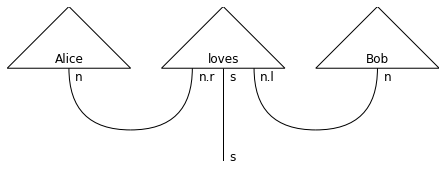

In [2]:
from discopy import Diagram, Id, Cup, pregroup

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
parsing = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj >> grammar
            for subj in [Alice, Bob] for verb in [loves] for obj in [Alice, Bob]}

diagram = parsing['Alice loves Bob.']
print("Diagram for 'Alice loves Bob':")
pregroup.draw(diagram, draw_types=True)

In [3]:
sentences = list(parsing.keys())
print("Grammatical sentences:\n{}".format('\n'.join(sentences)))

Grammatical sentences:
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.


In [7]:
from discopy.circuit import Gate, Ket, Rx, CX

H = Gate('H', 1, [1, 1, 1, -1])

def verb_ansatz(phase):
    return Ket(0, 0) >> H @ Rx(phase) >> CX

print(verb_ansatz(0).eval())

Matrix(dom=Dim(1), cod=Dim(2, 2), array=[(1+0j), 0j, 0j, (1+0j)])


Circuit for 'Alice loves Bob':


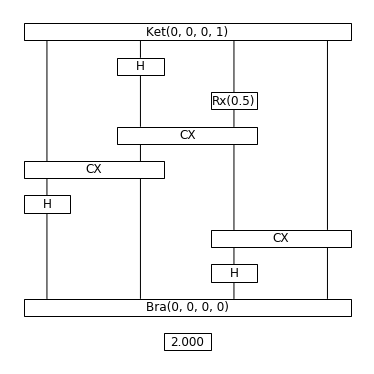

In [8]:
from discopy import CircuitFunctor

ob = {s: 0, n: 1}
ar = lambda params: {
    Alice: Ket(0), Bob: Ket(1),
    loves: verb_ansatz(params['loves'])}

F = lambda params: CircuitFunctor(ob, ar(params))

params0 = {'loves': 0.5}

print("Circuit for 'Alice loves Bob':")
F(params0)(parsing['Alice loves Bob.']).normal_form().draw(
    aspect='auto', draw_types=False, figsize=(5, 5))

In [9]:
print("Amplitude for 'Alice loves Bob':")
print(F(params0)(parsing['Alice loves Bob.']).eval())

Amplitude for 'Alice loves Bob':
Matrix(dom=Dim(1), cod=Dim(1), array=[(0.9999999+4.371139e-08j)])


In [10]:
evaluate = lambda F, sentence: F(parsing[sentence]).measure()

print("Does Alice love Bob?\n{}".format(
    "Yes" if evaluate(F(params0), 'Alice loves Bob.') else "No"))

Does Alice love Bob?
Yes


In [11]:
corpus = {sentence: evaluate(F(params0), sentence) for sentence in sentences}

epsilon = 1e-2

print("True sentences:\n{}\n".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability > 1 - epsilon)))
print("False sentences:\n{}".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability < epsilon)))

True sentences:
Alice loves Bob.
Bob loves Alice.

False sentences:
Alice loves Alice.
Bob loves Bob.


In [12]:
import jax.numpy as np
from jax import grad

def mean_squared(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

loss = lambda corpus, phase: mean_squared(*zip(*[
    (evaluate(F(params0), sentence), evaluate(F({'loves': phase}), sentence))
     for sentence in corpus]))

grad(lambda phase: loss(sentences, phase))(0.75)

DeviceArray(3.1415915, dtype=float32)

In [13]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.25, random_state=42)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(map(
    lambda x: 'Does ' + x.replace('loves', 'love').replace('.', '?'), sentence_test))))

Training set:
Bob loves Bob.
Alice loves Alice.
Bob loves Alice.

Testing set:
Does Alice love Bob?


In [14]:
training_loss = lambda phase: -loss(sentence_train, phase[0])
testing_loss = lambda phase: -loss(sentence_test, phase[0])

In [15]:
from random import random
import noisyopt

print("Random parameter initialisation...")

params = np.array([random()])
print("Initial parameters: {}".format(params))
print("Initial testing loss: {:.5f}\n".format(testing_loss(params)))

noisyopt.minimizeSPSA(training_loss, params, paired=False, callback=print, niter=10)

Random parameter initialisation...
Initial parameters: [0.9008366]
Initial testing loss: -0.82092

[0.9008367]
[0.7572703]
[0.57788706]
[0.54417276]
[0.5229056]
[0.5104506]
[0.504193]
[0.5015006]
[0.50048774]
[0.5001465]


     fun: DeviceArray(-4.8878246e-14, dtype=float32)
 message: 'terminated after reaching max number of iterations'
    nfev: 20
     nit: 10
 success: True
       x: DeviceArray([0.5001465], dtype=float32)

In [17]:
result = Out[15]
testing_loss(result.x)

DeviceArray(-5.684342e-14, dtype=float32)

In [18]:
print("Does Alice love Bob?")

print("Yes" if evaluate(F({'loves': result.x[0]}), 'Alice loves Bob.') > 1 - epsilon else "No")

Does Alice love Bob?
Yes
